<a href="https://colab.research.google.com/github/Pythonash/Projects/blob/Brain/XAI_with_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 타이타닉 데이터셋 구축하기

- 내가(pythonash) 만든 tidy dataset으로, 타이타닉 생존자예측 top 5%를 달성하게 해준 데이터셋으로 진행한다.

- 코드를 실행함에 있어 모든 데이터셋의 기준이 될 예정이다. `필요시 추가`



In [26]:
#==========필요한 모듈 다운로드==========#
!pip install pdpbox
import pandas as pd
import numpy as np
import tensorflow as tf
from pdpbox import info_plots
#==========필요한 데이터셋 구축==========#
def build_setting():
  train_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/train_x.csv')
  val_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/val_x.csv')
  train_y = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/train_y.csv')
  val_y = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/val_y.csv')
  test_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/test_x.csv')
  
  df_x = pd.concat([train_x, val_x],axis=0)
  df_y = pd.concat([train_y, val_y],axis=0)
  df = pd.concat([df_x, df_y], axis=1)
  #==========간단한 딥러닝 모델 구축==========#  
  deep_model = tf.keras.models.Sequential([
                                      tf.keras.layers.Input(shape = [len(df_x.columns)]),
                                      tf.keras.layers.Dense(8, activation = 'relu'),
                                      tf.keras.layers.Dense(8, activation = 'relu'),
                                      tf.keras.layers.Dense(8, activation = 'relu'),
                                      tf.keras.layers.Dense(8, activation = 'relu'),
                                      tf.keras.layers.Dense(1, activation = 'sigmoid')])
  deep_model.compile(loss = 'binary_crossentropy', metrics=['accuracy'], optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))
  return df, df_x, df_y, test_x, deep_model

df, train_x, train_y, test_x, model = build_setting()

# 부분 의존성 플랏

- 피처의 `수치 변화에 따라 모델에 기여하는 정도`가 어떻게 달라지는지 확인 할 수 있는 XAI기법.

- 궁금한 피처가 `긍정/부정의 영향`을 미치는지 파악하게 해준다.

- 특정 피처에 대해 `버퍼존을 표시`해줌으로써 피쳐간 `독립성이 성립되지 않는 환경`에서 어느 정도 `모델에 오차`가 있을 수 있는지 확인하게 해준다.

- 피처 간 `종속관계가 있을 때에도 활용이 가능` 하다.

## info_plots.target_plot()

- 일단 이 모델은 `학습된 모델을 파라미터로 받지 않는다.`

- 이는 학습데이터를 분석해서 `모델이 어떻게 학습할 것인지 예상하는 XAI 기법`이다.

- 만약 `특정 피쳐의 데이터 구조가 편향`(남자 98%, 여자 2% 분포 등) 되어 있다면, 그 `데이터에 맞춰 결론이 왜곡`돼 있을 수 있다.

그렇다면, 모델을 뜯어보지 않아도 `어떤 편향으로 모델이 학습될지 파악가능`하다.

그리고 이러한 알고리즘을 구현해 놓은 것이 pdpbox 패키지 이다.

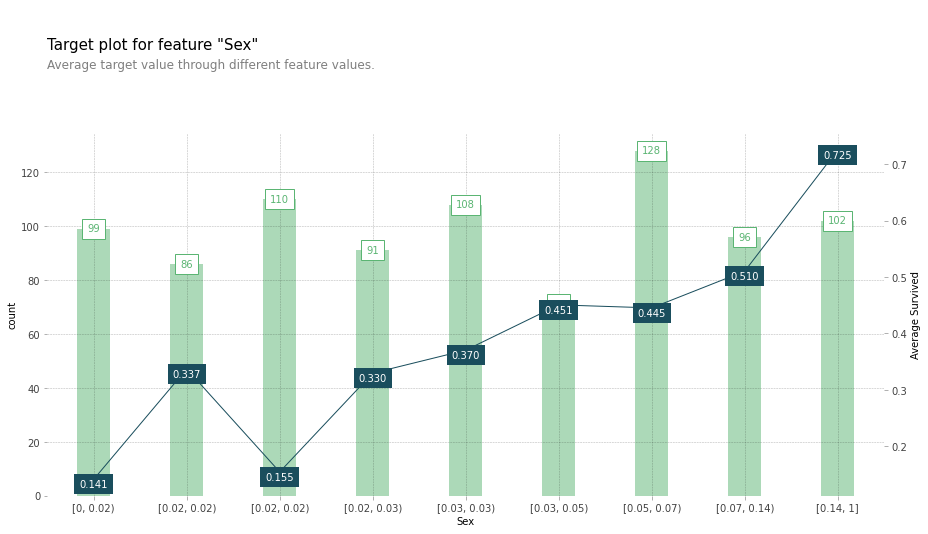

In [17]:
fig, axes, summary_df = info_plots.target_plot(
    df = df, # 피쳐 + 타겟 데이터
    feature = 'Fare', # 피쳐
    feature_name = 'Sex', # 표시할 이름
    target = 'Survived' # 타겟
)

`X 축은 피쳐`에 대한 정보, `왼쪽 Y축`은 각 수치 혹은 구간별 `데이터 수`, `오른쪽 Y축`은 `타겟(생존여부)에 대한 확률, 혹은 예상 값`이다.

`막대 그래프는 왼쪽 Y축`, `꺾은선 그래프는 오른쪽 Y축`에 대응한다.


이 그래프를 예로 들면, **Fare**의 경우(지금은 정규화 되어 0과 1사이의 값을 가짐) `0과 0.02` 사이에 속한 그룹은 데이터 개수는 99개, 이때 생존확률은 `14.1%`가 된다.

반대로, `0.14 ~ 1`사이에 속한 그룹의 경우 데이터 개수는 102개로 이때 생존 확률은 `72.5%`에 육박한다.



## 부분 의존성 플랏 결과 저장

- 결과를 DataFrame 포맷으로 저장한다.

In [19]:
summary_df

,x,display_column,value_lower,value_upper,count,Survived
0,0,"[0, 0.02)",0.000000,0.015094,99,0.141414
1,1,"[0.02, 0.02)",0.015094,0.015412,86,0.337209
2,2,"[0.02, 0.02)",0.015412,0.016908,110,0.154545
3,3,"[0.02, 0.03)",0.016908,0.025374,91,0.329670
4,4,"[0.03, 0.03)",0.025374,0.032596,108,0.370370
5,5,"[0.03, 0.05)",0.032596,0.050749,71,0.450704
6,6,"[0.05, 0.07)",0.050749,0.068532,128,0.445312
7,7,"[0.07, 0.14)",0.068532,0.143462,96,0.510417
8,8,"[0.14, 1]",0.143462,1.000000,102,0.725490


# 예측 분포 플랏(prediction distribution plot)

- 데이터와 실제 모델을 결합해 두 결과가 일치하는지 확인 하는 방법

/usr/local/lib/python3.7/dist-packages/pdpbox/info_plots.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s = str(s)


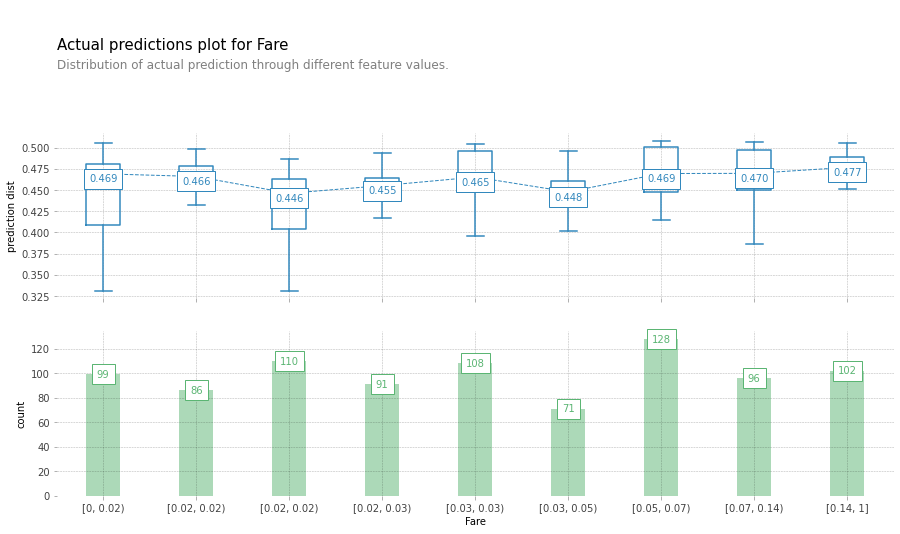

In [27]:
fig, axes, summary_df = info_plots.actual_plot(
    model = model,
    X = train_x,
    feature = 'Fare',
    feature_name = 'Fare',
    predict_kwds = {}
)